In [77]:
import os
import numpy as np
import pandas as pd
from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

DATA_ROOT = "./data/ml100marathon-02-01"

In [78]:
dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [79]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [80]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [81]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [82]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

In [83]:
dfoff.describe()

,User_id,Merchant_id,Coupon_id,Distance,Date_received,Date,label,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type
count,1.160742e+06,1.160742e+06,746969.000000,1.160742e+06,7.469690e+05,4.567090e+05,1.160742e+06,746969.000000,1160742.0,1.160742e+06,1.160742e+06,1.160742e+06,1.160742e+06,1.160742e+06,1.160742e+06,1.160742e+06,746969.000000,1.160742e+06,1.160742e+06,1.160742e+06
mean,3.690549e+06,4.103626e+03,7090.106124,8.517665e+00,2.016022e+07,2.016029e+07,-3.251963e-01,4.284368,0.0,1.027946e-01,6.420031e-02,6.573812e-02,7.902359e-02,1.083152e-01,9.316024e-02,1.302951e-01,0.850086,5.897446e+01,7.428939e+00,6.198707e-01
std,2.123784e+06,2.364912e+03,4159.042350,2.316903e+01,1.142962e+02,1.117400e+02,5.310339e-01,2.104181,0.0,3.036905e-01,2.451095e-01,2.478239e-01,2.697757e-01,3.107782e-01,2.906570e-01,3.366280e-01,0.086242,7.601693e+01,9.315331e+00,4.854186e-01
min,4.000000e+00,1.000000e+00,4.000000,0.000000e+00,2.016010e+07,2.016010e+07,-1.000000e+00,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.200000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.845197e+06,2.146000e+03,3304.000000,0.000000e+00,2.016013e+07,2.016020e+07,-1.000000e+00,2.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.833333,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.697362e+06,3.532000e+03,7610.000000,1.000000e+00,2.016020e+07,2.016032e+07,0.000000e+00,5.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.900000,3.000000e+01,5.000000e+00,1.000000e+00
75%,5.532561e+06,6.412000e+03,10323.000000,6.000000e+00,2.016032e+07,2.016040e+07,0.000000e+00,6.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.900000,1.000000e+02,1.000000e+01,1.000000e+00
max,7.361032e+06,8.856000e+03,14045.000000,9.900000e+01,2.016043e+07,2.016063e+07,1.000000e+00,7.000000,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.990000,3.000000e+02,1.000000e+02,1.000000e+00


In [84]:
dfoff.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,0,...,0,0,0,0,0,0,NaN,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,...,0,1,0,0,0,0,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,...,0,0,0,0,1,0,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,...,0,0,0,1,0,0,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,...,0,0,0,1,0,0,0.90,200,20,1


In [85]:
dfoff.dtypes

User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
label              int64
weekday          float64
weekday_type       int64
weekday_1          uint8
weekday_2          uint8
weekday_3          uint8
weekday_4          uint8
weekday_5          uint8
weekday_6          uint8
weekday_7          uint8
discount_rate    float64
discount_man       int64
discount_jian      int64
discount_type      int64
dtype: object

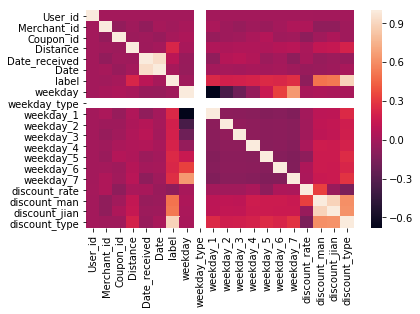

In [86]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = dfoff.corr()
sns.heatmap(corr)
plt.show()

In [87]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

train_Y = train["label"]
train_X = train.drop(["label"] , axis=1)

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [88]:
original_feature = ['discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday', 
                    'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [89]:
train_X = train_X[original_feature]
train_X.head()

,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.95,1,20,1,0.0,3.0,0,0,0,1,0,0,0,0
1,0.95,1,20,1,0.0,6.0,0,0,0,0,0,0,1,0
2,0.90,1,200,20,1.0,5.0,0,0,0,0,0,1,0,0
3,0.50,1,10,5,2.0,5.0,0,0,0,0,0,1,0,0
4,0.90,1,100,10,99.0,7.0,0,0,0,0,0,0,0,1


In [90]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in train_X.columns:
    train_X[c] = train_X[c].fillna(-1)
    if train_X[c].dtype == 'object':
        train_X[c] = LEncoder.fit_transform(list(train_X[c].values))
    train_X[c] = MMEncoder.fit_transform(train_X[c].values.reshape(-1, 1))
train_X.head()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.

,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.949367,1.0,0.066667,0.01,0.000000,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.949367,1.0,0.066667,0.01,0.000000,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.886076,1.0,0.666667,0.20,0.010101,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.379747,1.0,0.033333,0.05,0.020202,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.886076,1.0,0.333333,0.10,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [91]:
from sklearn.ensemble import GradientBoostingClassifier
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 
estimator = GradientBoostingClassifier()
estimator.fit(train_X.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=train_X.columns)
feats = feats.sort_values(ascending=False)
feats

Distance         0.469788
discount_man     0.321078
discount_rate    0.090192
discount_jian    0.074218
weekday          0.021087
weekday_5        0.009649
discount_type    0.006153
weekday_7        0.002380
weekday_2        0.002186
weekday_1        0.001530
weekday_3        0.001161
weekday_6        0.000573
weekday_4        0.000005
weekday_type     0.000000
dtype: float64

In [92]:
# 高重要性特徵
high_feature = list(feats[:9].index)
print(high_feature)

['Distance', 'discount_man', 'discount_rate', 'discount_jian', 'weekday', 'weekday_5', 'discount_type', 'weekday_7', 'weekday_2']


In [93]:
predictors = high_feature
print(predictors)

def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

['Distance', 'discount_man', 'discount_rate', 'discount_jian', 'weekday', 'weekday_5', 'discount_type', 'weekday_7', 'weekday_2']


In [94]:
train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,...,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type,is_train
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,...,1,0,0,0,0,0.95,20,1,1,True
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,...,0,0,0,1,0,0.95,20,1,1,True
2,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,...,0,0,1,0,0,0.90,200,20,1,True
3,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5.0,0,...,0,0,1,0,0,0.50,10,5,1,True
4,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,0,7.0,0,...,0,0,0,0,1,0.90,100,10,1,True


In [95]:
model = check_model(train, predictors)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.4min finished
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  Futur

In [96]:
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [97]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.746, Accuracy: 0.952


In [98]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

(306313, 19)
(306313, 10)


/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [99]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306313, 4)


In [100]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("ml100marathon-midterm-exam-ver1.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.102684
1,1000020_8192_20160513,0.088350
2,1000065_1455_20160527,0.067287
3,1000085_8067_20160513,0.070554
4,1000086_2418_20160613,0.070235
